In [1]:
import numpy as np
from scipy import constants as cst

import matplotlib.pyplot as plt
import tqdm
from labellines import labelLine, labelLines

from centrex_tlf import states, hamiltonian, transitions, couplings, lindblad, utils
from centrex_tlf_julia_extension import lindblad_julia

In [2]:
plt.rcParams.update({"font.size": 15})

In [3]:
def get_diagonal_indices_flattened(size, states=None, mode="python"):
    if states is None:
        indices = [i + size * i for i in range(size)]
    else:
        indices = [i + size * i for i in states]
    if mode == "julia":
        return [i + 1 for i in indices]
    elif mode == "python":
        return indices

In [4]:
trans = [
    transitions.OpticalTransition(
        transitions.OpticalTransitionType.R, J_ground=0, F1=1 / 2, F=1
    ),
]

polarizations = [
    [couplings.polarization_Z, couplings.polarization_X],
]

transition_selectors = couplings.generate_transition_selectors(
    trans,
    polarizations,
)

# Square Wave Polarization Switching

In [5]:
v_to_Γ = utils.detuning.velocity_to_detuning(1)

odepars = lindblad_julia.odeParameters(
    Ω0="Ωl0 * phase_modulation(t, β, ωphase)",
    Ωl0=1 * hamiltonian.Γ,  # Rabi frequency of the laser [rad/s]
    δ0=f"vx*{v_to_Γ}",  # detuning of the laser [rad/s]
    # laser phase modulation
    ωphase=hamiltonian.Γ,  # laser phase modulation frequency [rad/s]
    β=0.0,  # laser phase modulation depth [rad]
    ω0=2 * np.pi * 1.56e6,  # polarization switching frequency [rad/s]
    φ0=0.0,  # polarization switching phase [rad]
    P0="sin(ω0*t + φ0)",
    PZ0="P0>0",
    PX0="P0<=0",
    # molecules
    z0=0,  # molecule start z position [m]
    vz=184,  # longitudinal molecular velocity [m/s]
    vx=0,
)

In [6]:
obe_system = lindblad.setup_OBE_system_transitions(
    trans,
    transition_selectors,
    verbose=True,
    qn_compact=True,
    decay_channels=None,
    Jmax_X=3,
)

INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 1/5 -> Generating the reduced Hamiltonian
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 2/5 -> Generating the couplings corresponding to the transitions
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 3/5 -> Generating the symbolic Hamiltonian
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 4/5 -> Generating the collapse matrices
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 5/5 -> Transforming the Hamiltonian and collapse matrices into a symbolic system of equations


In [7]:
obe_system = lindblad_julia.setup_OBE_system_julia(
    obe_system, transition_selectors, odepars
)

In [8]:
ρ = utils.population.generate_uniform_population_states(
    states.QuantumSelector(J=0, F=[0, 1], electronic=states.ElectronicState.X),
    obe_system.QN,
)

rabi_rates = np.linspace(0, 1, 52)[1:] * hamiltonian.Γ
polarization_freqs = np.linspace(0, 2, 52)[1:] * hamiltonian.Γ

In [9]:
# only save excited state populations

state_selector = states.QuantumSelector(electronic=states.ElectronicState.B)
indices = state_selector.get_indices(obe_system.QN)

save_idxs = get_diagonal_indices_flattened(len(obe_system.QN), indices, mode="julia")

odepars.ωphase = 0.0
odepars.ω0 = 0.0

In [10]:
ensemble_config = lindblad_julia.OBEEnsembleProblemConfig(
    method="Tsit5()", save_idxs=save_idxs, saveat=1e-7, save_everystep=True
)

problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 5e-3 / odepars.vz))

scan_values = [rabi_rates, polarization_freqs]
parameters = ["Ωl0", "ω0"]

output_func = lindblad_julia.setup_state_integral_calculation_state_idxs(nphotons=True)


ensemble_problem = lindblad_julia.OBEEnsembleProblem(
    problem=problem,
    parameters=parameters,
    scan_values=scan_values,
    output_func=output_func,
)

lindblad_julia.setup_problem_parameter_scan(
    ensemble_problem,
)

lindblad_julia.solve_problem_parameter_scan(ensemble_problem, ensemble_config)

In [11]:
results_square = lindblad_julia.get_results_parameter_scan(scan=ensemble_problem)

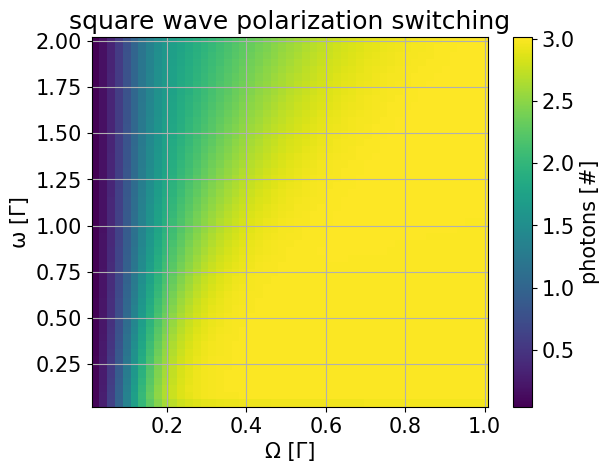

In [12]:
fig, ax = plt.subplots()
pcolor = ax.pcolormesh(
    *(np.asarray(results_square.scan_values) / hamiltonian.Γ), results_square.results
)

cbar = fig.colorbar(pcolor)
cbar.ax.set_ylabel("photons [#]")

ax.set_xlabel("Ω [Γ]")
ax.set_ylabel("ω [Γ]")
ax.set_title("square wave polarization switching")
ax.grid(True)

# Resonant Polarization Switching

In [13]:
v_to_Γ = utils.detuning.velocity_to_detuning(1)

odepars = lindblad_julia.odeParameters(
    Ω0="Ωl0 * phase_modulation(t, β, ωphase)",
    Ωl0=1 * hamiltonian.Γ,  # Rabi frequency of the laser [rad/s]
    δ0=f"vx*{v_to_Γ}",  # detuning of the laser [rad/s]
    # laser phase modulation
    ωphase=hamiltonian.Γ,  # laser phase modulation frequency [rad/s]
    β=0.0,  # laser phase modulation depth [rad]
    ω0=2 * np.pi * 1.56e6,  # polarization switching frequency [rad/s]
    φ0=0.0,  # polarization switching phase [rad]
    PZ0="resonant_switching(t, ω0, ϕ0)",
    PX0="1-PZ0",
    # molecules
    z0=0,  # molecule start z position [m]
    vz=184,  # longitudinal molecular velocity [m/s]
    vx=0,
)

In [14]:
obe_system = lindblad.setup_OBE_system_transitions(
    trans,
    transition_selectors,
    verbose=True,
    qn_compact=True,
    decay_channels=None,
    Jmax_X=3,
)

INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 1/5 -> Generating the reduced Hamiltonian
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 2/5 -> Generating the couplings corresponding to the transitions
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 3/5 -> Generating the symbolic Hamiltonian
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 4/5 -> Generating the collapse matrices
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 5/5 -> Transforming the Hamiltonian and collapse matrices into a symbolic system of equations


In [15]:
obe_system = lindblad_julia.setup_OBE_system_julia(
    obe_system, transition_selectors, odepars
)

In [16]:
ρ = utils.population.generate_uniform_population_states(
    states.QuantumSelector(J=0, F=[0, 1], electronic=states.ElectronicState.X),
    obe_system.QN,
)

rabi_rates = np.linspace(0, 1, 52)[1:] * hamiltonian.Γ
polarization_freqs = np.linspace(0, 2, 52)[1:] * hamiltonian.Γ

In [17]:
# only save excited state populations

state_selector = states.QuantumSelector(electronic=states.ElectronicState.B)
indices = state_selector.get_indices(obe_system.QN)

save_idxs = get_diagonal_indices_flattened(len(obe_system.QN), indices, mode="julia")

odepars.ωphase = 0.0
odepars.ω0 = 0.0

In [18]:
ensemble_config = lindblad_julia.OBEEnsembleProblemConfig(
    method="Tsit5()", save_idxs=save_idxs, saveat=1e-7, save_everystep=True
)

problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 5e-3 / odepars.vz))

scan_values = [rabi_rates, polarization_freqs]
parameters = ["Ωl0", "ω0"]

output_func = lindblad_julia.setup_state_integral_calculation_state_idxs(nphotons=True)


ensemble_problem = lindblad_julia.OBEEnsembleProblem(
    problem=problem,
    parameters=parameters,
    scan_values=scan_values,
    output_func=output_func,
)

lindblad_julia.setup_problem_parameter_scan(
    ensemble_problem,
)

lindblad_julia.solve_problem_parameter_scan(ensemble_problem, ensemble_config)

In [19]:
results_resonant = lindblad_julia.get_results_parameter_scan(scan=ensemble_problem)

# Results

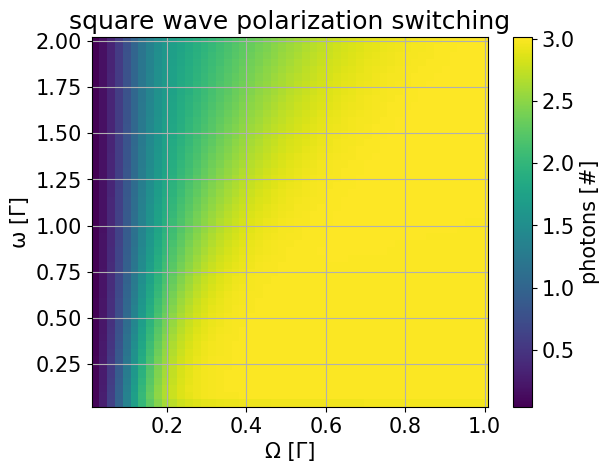

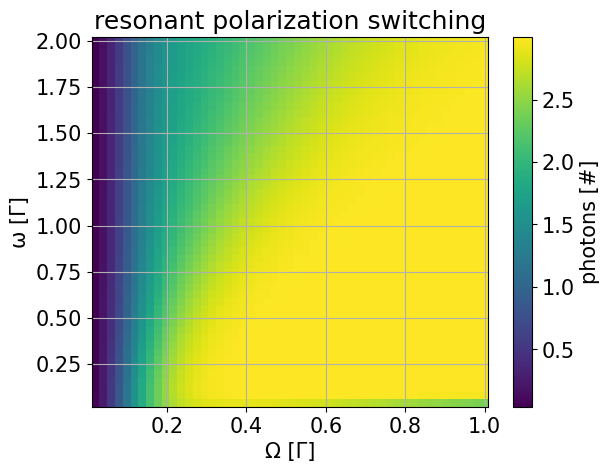

In [20]:
fig, ax = plt.subplots()
pcolor = ax.pcolormesh(
    *(np.asarray(results_square.scan_values) / hamiltonian.Γ), results_square.results
)

cbar = fig.colorbar(pcolor)
cbar.ax.set_ylabel("photons [#]")

ax.set_xlabel("Ω [Γ]")
ax.set_ylabel("ω [Γ]")
ax.set_title("square wave polarization switching")
ax.grid(True)

fig, ax = plt.subplots()
pcolor = ax.pcolormesh(
    *(np.asarray(results_resonant.scan_values) / hamiltonian.Γ),
    results_resonant.results,
)

cbar = fig.colorbar(pcolor)
cbar.ax.set_ylabel("photons [#]")

ax.set_xlabel("Ω [Γ]")
ax.set_ylabel("ω [Γ]")
ax.set_title("resonant polarization switching")
ax.grid(True)

## Difference

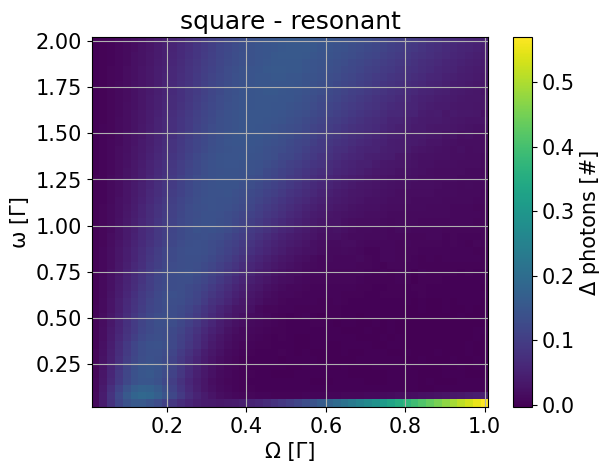

In [21]:
z = results_square.results - results_resonant.results

fig, ax = plt.subplots()
pcolor = ax.pcolormesh(
    *(np.asarray(results_resonant.scan_values) / hamiltonian.Γ),
    z,
)

cbar = fig.colorbar(pcolor)
cbar.ax.set_ylabel("Δ photons [#]")

ax.set_xlabel("Ω [Γ]")
ax.set_ylabel("ω [Γ]")
ax.set_title("square - resonant")
ax.grid(True)

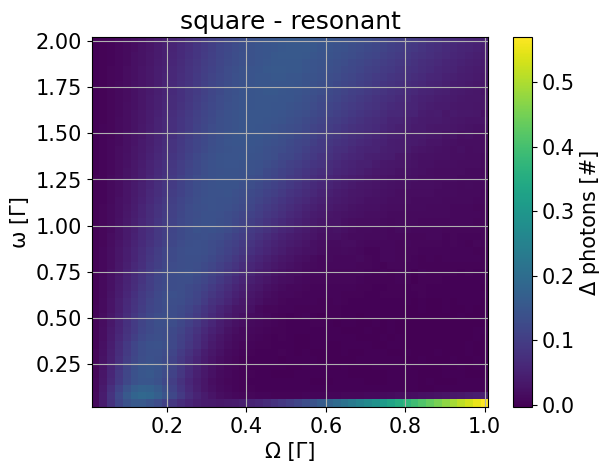

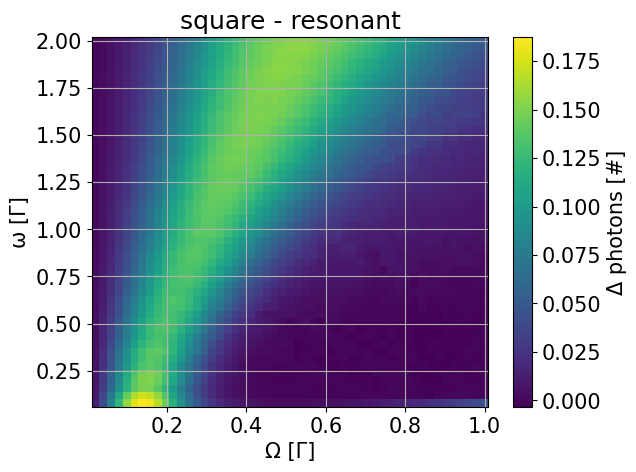

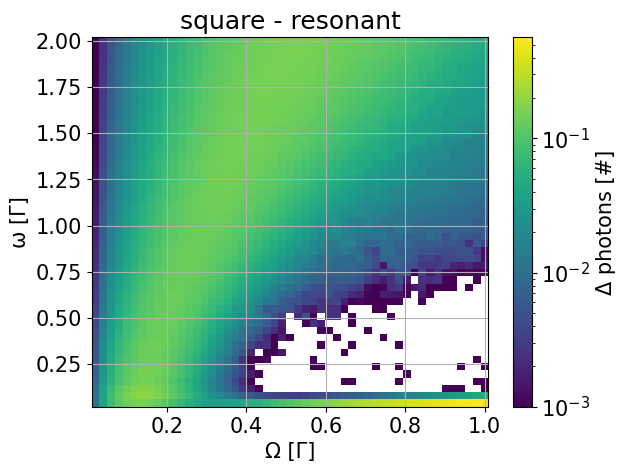

In [22]:
X, Y = np.asarray(results_resonant.scan_values) / hamiltonian.Γ
z = results_square.results - results_resonant.results

fig, ax = plt.subplots()
pcolor = ax.pcolormesh(
    X,
    Y,
    z,
)

cbar = fig.colorbar(pcolor)
cbar.ax.set_ylabel("Δ photons [#]")

ax.set_xlabel("Ω [Γ]")
ax.set_ylabel("ω [Γ]")
ax.set_title("square - resonant")
ax.grid(True)

fig, ax = plt.subplots()
pcolor = ax.pcolormesh(
    X[:, 1:],
    Y[:, 1:],
    z[:, 1:],
)

cbar = fig.colorbar(pcolor)
cbar.ax.set_ylabel("Δ photons [#]")

ax.set_xlabel("Ω [Γ]")
ax.set_ylabel("ω [Γ]")
ax.set_title("square - resonant")
ax.grid(True)

import matplotlib.colors as colors

fig, ax = plt.subplots()
pcolor = ax.pcolormesh(
    X,
    Y,
    z,
    norm=colors.LogNorm(vmin=1e-3, vmax=z.max()),
)

cbar = fig.colorbar(pcolor)
cbar.ax.set_ylabel("Δ photons [#]")

ax.set_xlabel("Ω [Γ]")
ax.set_ylabel("ω [Γ]")
ax.set_title("square - resonant")
ax.grid(True)

## Ratio

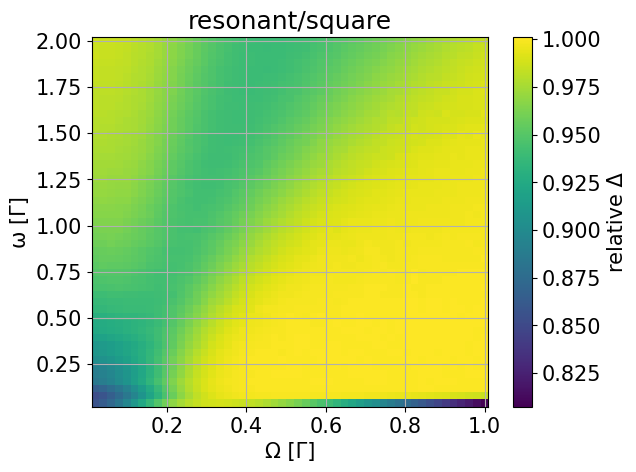

In [116]:
X, Y = np.asarray(results_resonant.scan_values) / hamiltonian.Γ
z = results_resonant.results / results_square.results

fig, ax = plt.subplots()
pcolor = ax.pcolormesh(
    X,
    Y,
    z,
)

cbar = fig.colorbar(pcolor)
cbar.ax.set_ylabel("relative Δ")

ax.set_xlabel("Ω [Γ]")
ax.set_ylabel("ω [Γ]")
ax.set_title("resonant/square")
ax.grid(True)

## Difference Ratio

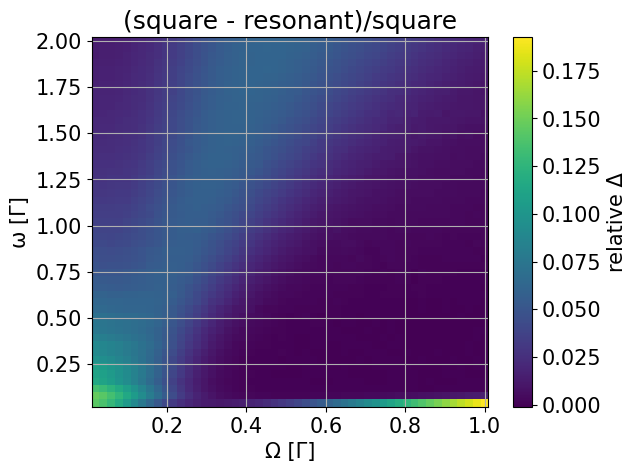

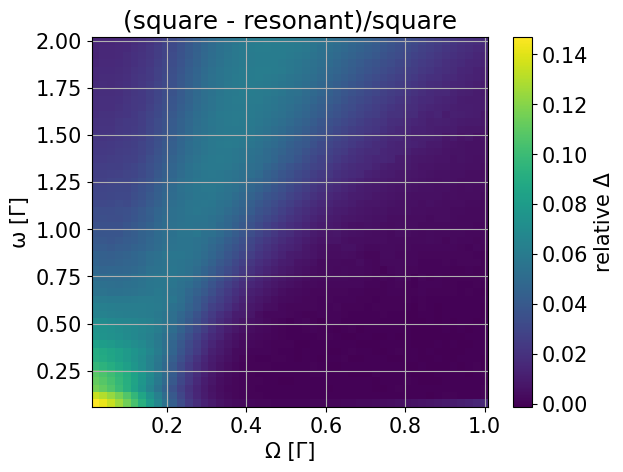

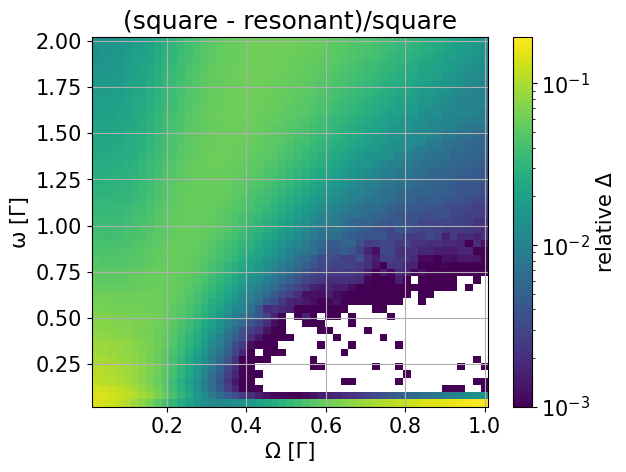

In [23]:
X, Y = np.asarray(results_resonant.scan_values) / hamiltonian.Γ
z = (results_square.results - results_resonant.results) / results_square.results

fig, ax = plt.subplots()
pcolor = ax.pcolormesh(
    X,
    Y,
    z,
)

cbar = fig.colorbar(pcolor)
cbar.ax.set_ylabel("relative Δ")

ax.set_xlabel("Ω [Γ]")
ax.set_ylabel("ω [Γ]")
ax.set_title("(square - resonant)/square")
ax.grid(True)

fig, ax = plt.subplots()
pcolor = ax.pcolormesh(
    X[:, 1:],
    Y[:, 1:],
    z[:, 1:],
)

cbar = fig.colorbar(pcolor)
cbar.ax.set_ylabel("relative Δ")

ax.set_xlabel("Ω [Γ]")
ax.set_ylabel("ω [Γ]")
ax.set_title("(square - resonant)/square")
ax.grid(True)

fig, ax = plt.subplots()
pcolor = ax.pcolormesh(
    X,
    Y,
    z,
    norm=colors.LogNorm(vmin=1e-3, vmax=z.max()),
)

cbar = fig.colorbar(pcolor)
cbar.ax.set_ylabel("relative Δ")

ax.set_xlabel("Ω [Γ]")
ax.set_ylabel("ω [Γ]")
ax.set_title("(square - resonant)/square")
ax.grid(True)

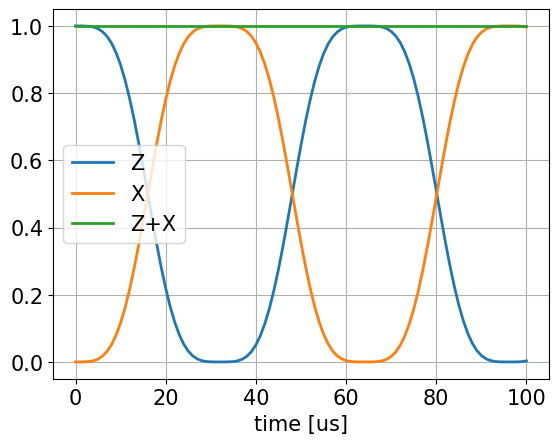

In [44]:
odepars.ω0 = hamiltonian.Γ
odepars.ϕ0 = 0.0

fig, ax = plt.subplots()
ax.plot(
    odepars.get_parameter_evolution(np.linspace(0, 1e-6, 101), "PZ0"), lw=2, label="Z"
)
ax.plot(
    odepars.get_parameter_evolution(np.linspace(0, 1e-6, 101), "PX0"), lw=2, label="X"
)
ax.plot(
    odepars.get_parameter_evolution(np.linspace(0, 1e-6, 101), "PZ0")
    + odepars.get_parameter_evolution(np.linspace(0, 1e-6, 101), "PX0"),
    lw=2,
    label="Z+X",
)

ax.set_xlabel("time [us]")
ax.legend()
ax.grid(True)

# Fixed polarization frequency scan detuning

In [104]:
ρ = utils.population.generate_uniform_population_states(
    states.QuantumSelector(J=0, F=[0, 1], electronic=states.ElectronicState.X),
    obe_system.QN,
)

rabi_rates = np.linspace(0, 1, 102)[1:] * hamiltonian.Γ
vx = np.linspace(-5, 5, 201)

In [105]:
# only save excited state populations

state_selector = states.QuantumSelector(electronic=states.ElectronicState.B)
indices = state_selector.get_indices(obe_system.QN)

save_idxs = get_diagonal_indices_flattened(len(obe_system.QN), indices, mode="julia")

odepars.ωphase = 0.0
odepars.ω0 = hamiltonian.Γ

In [106]:
ensemble_config = lindblad_julia.OBEEnsembleProblemConfig(
    method="Tsit5()", save_idxs=save_idxs, saveat=1e-7, save_everystep=True
)

problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 5e-3 / odepars.vz))

scan_values = [rabi_rates, vx]
parameters = ["Ωl0", "vx"]

output_func = lindblad_julia.setup_state_integral_calculation_state_idxs(nphotons=True)


ensemble_problem = lindblad_julia.OBEEnsembleProblem(
    problem=problem,
    parameters=parameters,
    scan_values=scan_values,
    output_func=output_func,
)

lindblad_julia.setup_problem_parameter_scan(
    ensemble_problem,
)

lindblad_julia.solve_problem_parameter_scan(ensemble_problem, ensemble_config)

In [107]:
results_detuning_scan = lindblad_julia.get_results_parameter_scan(scan=ensemble_problem)

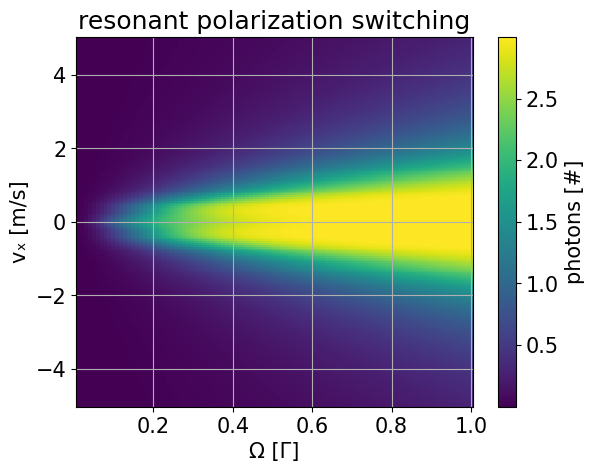

In [108]:
X, Y = np.asarray(results_detuning_scan.scan_values) / hamiltonian.Γ
Y *= hamiltonian.Γ

z = results_detuning_scan.results

fig, ax = plt.subplots()
pcolor = ax.pcolormesh(
    X,
    Y,
    z,
)

cbar = fig.colorbar(pcolor)
cbar.ax.set_ylabel("photons [#]")

ax.set_xlabel("Ω [Γ]")
ax.set_ylabel("vₓ [m/s]")
ax.set_title("resonant polarization switching")
ax.grid(True)

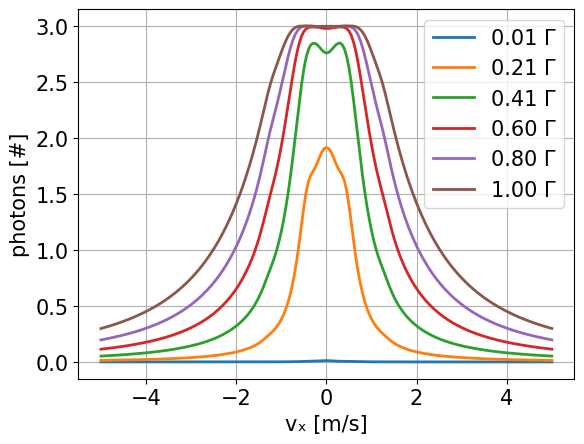

In [110]:
fig, ax = plt.subplots()

ax.plot(Y[0, :], z[::20, :].T, lw=2, label=[f"{li:.2f} Γ" for li in X[::20, 0]])

ax.set_xlabel("vₓ [m/s]")
ax.set_ylabel("photons [#]")

ax.legend()
ax.grid(True)